MODELO DE MACHINE LEARNING

In [499]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None #Configuro pandas para que muetre todas las columnas`

import time
import random

from matplotlib import pyplot as plt
import seaborn as sns
import pandas_profiling
from matplotlib.ticker import FormatStrFormatter
import ast
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

from matplotlib import style
style.use('dark_background')


import json #se utilizara para convertir los campos tipo json

# ADQUISICIÓN DE DATOS

Trabajaremos con dos dataframes.

    -df_solar_wind contiene en cada fila una toma de mediciones de los satélites. Se toma una medición por minuto.

    -df_dst contiene en cada fila una medición de la magnitud dst (tomadas en observatorios en la Tierra). Se toman mediciones cada una hora.

Cada 60 mediciones de satélite, hay una de dst.

Las mediciones dst son una medida de cuánto se debilita la... de la tierra.

El objetivo es poder entrenar un modelo para poder predecir el dst previo al arrivo de las ondas solares a la Tierra.

In [589]:
df_solar_wind = pd.read_csv('Dataset/solar_wind.csv')
df_dst = pd.read_csv('Dataset/labels.csv')

In [501]:
#Para observar de antemano los dataframe, descomentar alguno de estos

df_solar_wind
#df_dst

,period,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source
0,train_a,0 days 00:00:00,-5.55,3.00,1.25,11.09,153.37,-5.55,3.00,1.25,11.09,153.37,6.80,1.53,383.92,110237.0,ac
1,train_a,0 days 00:01:00,-5.58,3.16,1.17,10.10,151.91,-5.58,3.16,1.17,10.10,151.91,6.83,1.69,381.79,123825.0,ac
2,train_a,0 days 00:02:00,-5.15,3.66,0.85,7.87,146.04,-5.15,3.66,0.85,7.87,146.04,6.77,1.97,389.11,82548.0,ac
3,train_a,0 days 00:03:00,-5.20,3.68,0.68,6.17,146.17,-5.20,3.68,0.68,6.17,146.17,6.74,1.97,389.11,82548.0,ac
4,train_a,0 days 00:04:00,-5.12,3.68,0.49,4.62,145.72,-5.12,3.68,0.49,4.62,145.72,6.65,1.77,384.26,94269.0,ac
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8392315,train_c,2435 days 23:55:00,-1.18,2.00,-3.92,-59.28,120.51,-1.17,2.98,-3.23,-45.24,111.48,4.56,4.64,348.73,23368.0,ac
8392316,train_c,2435 days 23:56:00,-1.34,2.12,-3.83,-56.78,122.23,-1.33,3.08,-3.12,-42.95,113.45,4.58,4.27,346.36,26497.0,ac
8392317,train_c,2435 days 23:57:00,-1.62,2.33,-3.63,-51.98,124.76,-1.61,3.22,-2.87,-38.57,116.58,4.61,3.95,344.12,27050.0,ac
8392318,train_c,2435 days 23:58:00,-2.27,2.48,-3.22,-43.81,132.50,-2.26,3.25,-2.44,-31.61,124.81,4.65,2.81,338.52,33257.0,ac


# Limpieza de dataframe

Quitamos los datos que, por lo que hemos investigado, no nos son relevantes para el estudio en cuestión.

In [590]:
df_solar_wind.drop(columns=['bx_gse', 'by_gse', 'theta_gse', 'phi_gse', 'bx_gsm', 'by_gsm', 'theta_gsm', 'phi_gsm', 'period','source', 'timedelta', 'bz_gsm'], inplace=True)
df_solar_wind

,bz_gse,bt,density,speed,temperature
0,1.25,6.80,1.53,383.92,110237.0
1,1.17,6.83,1.69,381.79,123825.0
2,0.85,6.77,1.97,389.11,82548.0
3,0.68,6.74,1.97,389.11,82548.0
4,0.49,6.65,1.77,384.26,94269.0
...,...,...,...,...,...
8392315,-3.92,4.56,4.64,348.73,23368.0
8392316,-3.83,4.58,4.27,346.36,26497.0
8392317,-3.63,4.61,3.95,344.12,27050.0
8392318,-3.22,4.65,2.81,338.52,33257.0


Como podremos ver, hay varias filas con valores NaN. No podemos eliminarlos porque 60 mediciones corresponden a un valor de DST (que sería como nuestra puntuación). Por lo tanto aproximaremos los valores NaN con la interpolación lineal entre las mediciones vecinas.

In [591]:
#Cantidad de valores NaN por columna

print('Cantidad de valores Nan por columna:')
df_solar_wind.isna().sum().sort_values()

Cantidad de valores Nan por columna:


bz_gse         325888
bt             325888
density        684890
speed          689555
temperature    811768
dtype: int64

In [592]:
#Realizamos interpolación.
df_solar_wind.interpolate(limit_direction='both', inplace=True)
#Limit both se usa para interpolar en caso de que en los extremos superior o inferior también hayan valores NaN.

In [593]:
#Comprobamos que no hay valores NaN:
print('Cantidad de valores Nan por columna:')
df_solar_wind.isna().sum().sort_values()

Cantidad de valores Nan por columna:


bz_gse         0
bt             0
density        0
speed          0
temperature    0
dtype: int64

## Análisis preliminar de datos



In [506]:
df_solar_wind.describe()

,bz_gse,bt,density,speed,temperature
count,8.392320e+06,8.392320e+06,8.392320e+06,8.392320e+06,8.392320e+06
mean,-2.155260e-02,5.617213e+00,4.407689e+00,4.301172e+02,1.132176e+05
std,3.346154e+00,3.114910e+00,4.408094e+00,1.002283e+02,1.202403e+05
min,-5.500000e+01,3.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00
25%,-1.700000e+00,3.640000e+00,1.780000e+00,3.566900e+02,3.906400e+04
50%,1.000000e-02,4.960000e+00,3.310000e+00,4.093485e+02,7.630500e+04
75%,1.690000e+00,6.730000e+00,5.660000e+00,4.845700e+02,1.484220e+05
max,7.403000e+01,8.053000e+01,1.997000e+02,1.198490e+03,6.223700e+06


In [507]:
df_dst.describe()

,dst
count,139872.000000
mean,-11.055236
std,19.069327
min,-387.000000
25%,-18.000000
50%,-8.000000
75%,0.000000
max,67.000000


Podemos ver que el mínimo sdt observado es -387. Según nuestra investigación, de 0 a -50 es tormenta leve, de -50 a -100 es tormenta moderada, de -100 a -250 es tormenta severa y menor a -250 es super tormenta.

<AxesSubplot:xlabel='dst', ylabel='Density'>

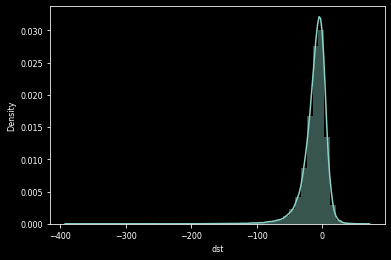

In [508]:
sns.distplot(df_dst['dst'])

In [509]:
np.percentile(df_dst['dst'],3)

-52.0

Mediante el gráfico, podemos ver que aproximadamente menos del 3% de los datos dan como resultado un dst menor al -50 (hasta -50 es tormenta leve)

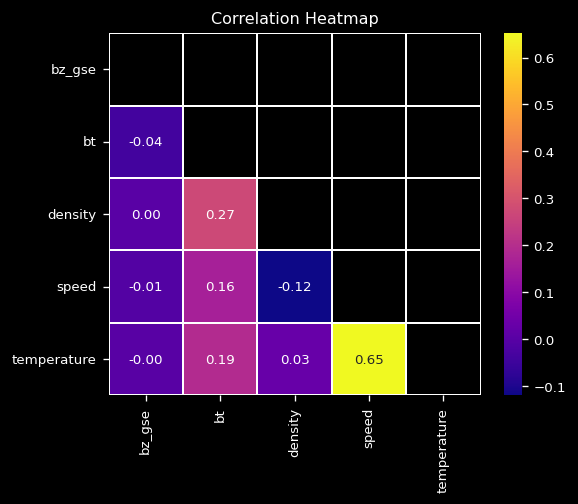

In [510]:
plt.rcParams.update({'font.size': 8})
plt.figure(dpi = 120,figsize= (5,4), )
mask = np.triu(np.ones_like(df_solar_wind.corr(),dtype = bool))
sns.heatmap(df_solar_wind.corr(),mask = mask, fmt = ".2f",annot=True,lw=1,cmap = 'plasma')
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.title('Correlation Heatmap')
plt.show()

Entre las variables del dataframe solar_wind, podemos ver que no hay correlaciones relevantes entre ellas. Sí se puede observar, que cuando la velocidad es alta, la temperatura también tiende a ser alta.

# Preparación de dataset para modelo de ML

Como por cada 60 mediciones, cada una con sus variables, tienen como resultado un solo valor dst, tengo que encontrar la forma de unificar las mediciones para que quede como 1 medición promedio para un solo valor de dst.

In [511]:
#Veremos a qué me refiero con esto:

print('Número total de mediciones dividido 60:\n\t' + str(len(df_solar_wind)//60))
print('Número de valores dts:\n\t' + str(len(df_dst)))


Número total de mediciones dividido 60:
	139872
Número de valores dts:
	139872


NOTA IMPORTANTE. Para disminuir el tiempo de procesamiento, en vez de tomar los casi 140000 datos, se tomaron únicamente 20000

Si hay tiempo, ampliaremos la muestra

In [512]:
''' COMENTADO PORQUE ESTE PROCESO DE IR APROXIMANDO DE A 60 DATOS DEMORA BASTANTE TIEMPO. EL DATAFRAME RESULTANTE FUE GUARDADO COMO df_prom_solar.csv PARA EVITAR ESTE PASO
'''

#Creo el dataframe que tendrá como filas, el promedio de 60 mediciones.
df_prom_solar = pd.DataFrame(columns=['bz_gse', 'bt', 'density', 'speed', 'temperature'])


#Creo la lista de índices para elegir de forma aleatoria el primero de cada conjunto
indice_primeros = []


#Como los conjuntos de datos vienen de a 60, creo una lista con tódos los índices posibles que podría seleccionar. Estos índices apuntan al primero de los grupos de 60.
lista_indices = list(range(0, len(df_solar_wind), 60))

#Acá almacenaré los índices seleccionados para luego saber qué dst seleccionar.
indices_seleccionados = []



for j in range(30000):#range( len(df_solar_wind) // 60 ):
    
    inicio = time.time()

    indice_aleatorio = random.choice(lista_indices) #Selecciono índice al azar
    lista_indices.remove(indice_aleatorio)          #Elimino el ya seleccionado para evitar repetición
    indices_seleccionados.append(indice_aleatorio//60)             #Agrego a la lista de índices seleccionados, pero dividido 60 (porque en el dataframe de dst es 60 veces más chico)
    
    df_auxiliar = pd.DataFrame(columns=['bz_gse', 'bt', 'density', 'speed', 'temperature']) #Iré guardando de a 60 filas para luego sacarles el promedio y almacenarlos en df_prom_solar
    #Cada vez que se llega a este punto, se vacía el dataframe
    
    for i in range(60):
        
        df_auxiliar.loc[i] = df_solar_wind.iloc[i+indice_aleatorio]


    df_prom_solar.loc[j] = df_auxiliar.mean()
    #df_prom_solar = df_prom_solar.append(df_auxiliar.mean(), ignore_index=True)

    final = time.time()
    

print('Tiempo: ' + str(final-inicio))

print(df_prom_solar)

df_prom_solar.to_csv('df_prom_solar.csv', index=False)

''''''




Tiempo: 0.040009260177612305
         bz_gse         bt   density       speed    temperature
0     -3.875500   5.134167  1.185917  303.283333   21103.516667
1     -0.874220   5.272708  2.374045  364.244171   59822.326633
2     -1.213500   2.473833  5.563000  372.861500   49186.975000
3     -0.125833   5.070000  1.040167  457.095500  103177.250000
4      1.333333   3.011333  2.990167  466.981583   94919.558333
...         ...        ...       ...         ...            ...
29995 -1.696667   2.009667  2.254917  293.261167   33636.458333
29996 -2.317333  11.792500  4.201083  457.554583   29569.691667
29997  1.045667   2.727167  4.996167  343.526667    8554.333333
29998 -1.230833   7.768833  7.129583  396.833750  120941.550000
29999 -1.694000   8.413333  4.430167  454.191000  172187.416667

[30000 rows x 5 columns]


''

In [612]:
# Importamos dataframe donde cada fila son aproximaciones de 60 mediciones
df_prom = pd.read_csv('df_prom_solar.csv')

#Dropeo la columna de velocidad

#df_prom.drop(columns=['temperature'], inplace=True)

df_prom['dst'] = 0.0

for i in range(len(df_prom) ):
    df_prom['dst'][i] = df_dst.iloc[ indices_seleccionados[i] ]['dst']

df_prom

,bz_gse,bt,density,speed,temperature,dst
0,-3.875500,5.134167,1.185917,303.283333,21103.516667,14.0
1,-0.874220,5.272708,2.374045,364.244171,59822.326633,-2.0
2,-1.213500,2.473833,5.563000,372.861500,49186.975000,13.0
3,-0.125833,5.070000,1.040167,457.095500,103177.250000,3.0
4,1.333333,3.011333,2.990167,466.981583,94919.558333,-8.0
...,...,...,...,...,...,...
29995,-1.696667,2.009667,2.254917,293.261167,33636.458333,1.0
29996,-2.317333,11.792500,4.201083,457.554583,29569.691667,-31.0
29997,1.045667,2.727167,4.996167,343.526667,8554.333333,-1.0
29998,-1.230833,7.768833,7.129583,396.833750,120941.550000,11.0


## Análisis de correlación entre variables y dst en el dataframe a analizar

In [613]:
df_prom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bz_gse       30000 non-null  float64
 1   bt           30000 non-null  float64
 2   density      30000 non-null  float64
 3   speed        30000 non-null  float64
 4   temperature  30000 non-null  float64
 5   dst          30000 non-null  float64
dtypes: float64(6)
memory usage: 1.4 MB


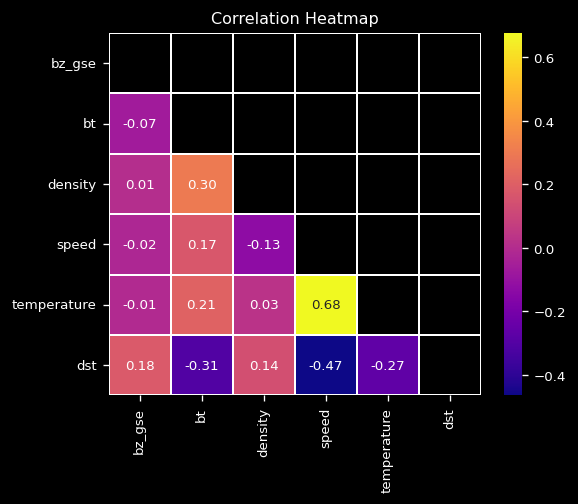

In [614]:
plt.rcParams.update({'font.size': 8})
plt.figure(dpi = 120,figsize= (5,4), )
mask = np.triu(np.ones_like(df_prom.corr(),dtype = bool))
sns.heatmap(df_prom.corr(),mask = mask, fmt = ".2f",annot=True,lw=1,cmap = 'plasma')
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.title('Correlation Heatmap')
plt.show()

Podemos ver que no hay gran relacion entre las variables independientes y nuestra variable objetivo. Esto nos permite que pueda generarse un modelo que sea equitativo a la hora de darle un peso a cada variable.

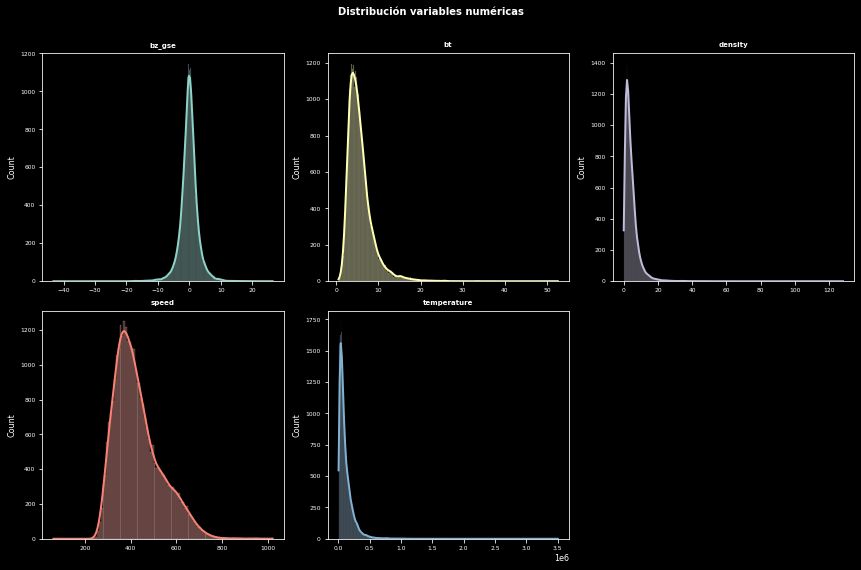

In [625]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flat
columnas_numeric = df_prom.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('dst')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = df_prom,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [5]:
    fig.delaxes(axes[i])
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

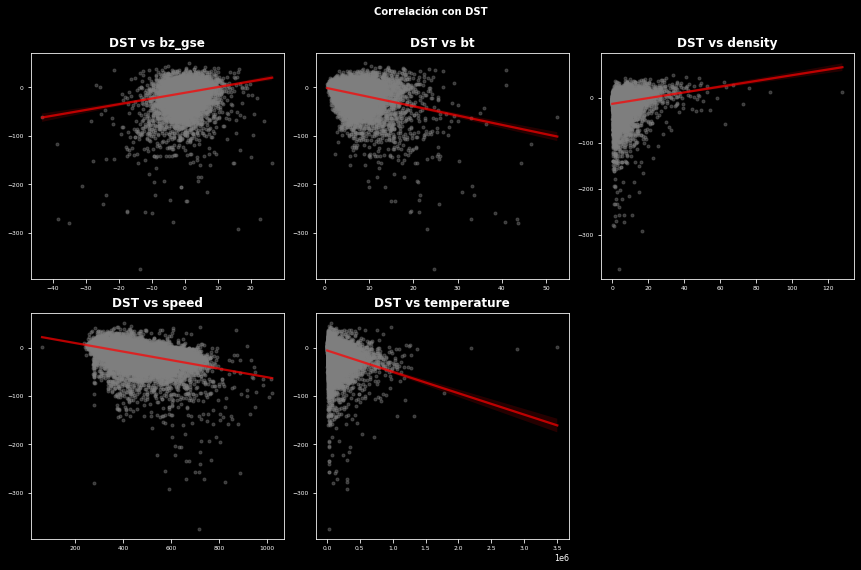

In [628]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flat
columnas_numeric = df_prom.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('dst')

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = df_prom[colum],
        y           = df_prom['dst'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"DST vs {colum}", fontsize = 12, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    #axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    #axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [5]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con DST', fontsize = 10, fontweight = "bold");

## Preparación del dataframe para entrenar al modelo

Separaremos inputs de los outputs:

In [515]:
X = df_prom.drop(columns=['dst'])
y = df_prom['dst'].values

Realizaremos una normalizacion de los predictores para que todos estén en la misma escala. De esta forma se evita que los que tengan mayor magnitud o varianza influencien en gran medida al modelo.

In [516]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[0.56442357, 0.08861381, 0.00922832, 0.25115356, 0.00485776],
       [0.60746347, 0.09127633, 0.01849861, 0.31471375, 0.01592104],
       [0.60259802, 0.03748709, 0.04338019, 0.32369852, 0.01288216],
       ...,
       [0.63499564, 0.04235569, 0.03895752, 0.29311286, 0.00127203],
       [0.60234945, 0.13924726, 0.05560334, 0.34869294, 0.03338488],
       [0.59570741, 0.15163337, 0.03454134, 0.40849589, 0.04802758]])

Creamos los sets de entrenamiento y de prueba

In [640]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=45)

# Usando Bayesian Ridge Regression

Entrenamos el modelo y comprobamos primeros resultados

In [518]:
from sklearn.linear_model import BayesianRidge
regressor = BayesianRidge()

# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

#Realizamos una predicción
y_train_pred = regressor.predict(X_train) #Prediccion en Train
y_test_pred = regressor.predict(X_test) #Prediccion en Test

#Convertimos en df la salida
df = pd.DataFrame({'Actual':y_test, 'Predicted': y_test_pred})
df

,Actual,Predicted
0,-20,-10.691843
1,-5,-2.156694
2,-8,-1.068022
3,-4,-7.921621
4,5,-19.443969
...,...,...
8995,-34,-29.382985
8996,-30,-29.894146
8997,-16,-27.174502
8998,-13,-6.937555


Mean Absolute Error: 10.480562024949025
Mean Squared Error: 264.9095591458944
Root Mean Squared Error: 16.276042490295186


Text(0.5, 1.0, 'DST vs Predicted DST')

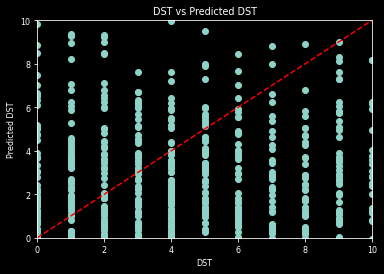

In [519]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,y_test_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,y_test_pred)))

plt.axis([0,10,0,10])
plt.scatter(y_test, y_test_pred)

index_arr = [n for n in range(11)]
plt.plot(index_arr,'r--')             
plt.xlabel("DST")
plt.ylabel("Predicted DST")
plt.title("DST vs Predicted DST")

In [520]:
from sklearn.metrics import r2_score

score = r2_score(y_test, y_test_pred)

print("R^2 Score for predictions:", score)
print("R2 adjusted:", 1 - (1-score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

R^2 Score for predictions: 0.3346662813184671
R2 adjusted: 0.33429640489046974


Podemos observar que los resultados no son del todo buenos. Hay que continuar probando con otros modelos.

# Regresión lineal

In [562]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()

# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

#Realizamos una predicción
y_train_pred = regressor.predict(X_train) #Prediccion en Train
y_test_pred = regressor.predict(X_test) #Prediccion en Test

#Convertimos en df la salida
df = pd.DataFrame({'Actual':y_test, 'Predicted': y_test_pred})
df.sample(5)

,Actual,Predicted
8134,-21,-16.360018
6691,-9,-25.888929
7178,1,-5.880538
4417,-13,-22.260610
3825,3,2.277771


In [563]:
from sklearn.metrics import r2_score

score = r2_score(y_test, y_test_pred)

print("R^2 Score for predictions:", score)
print("R2 adjusted:", 1 - (1-score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

R^2 Score for predictions: 0.3347098784503023
R2 adjusted: 0.33434002625909165


Mean Absolute Error: 10.481059135200033
Mean Squared Error: 264.89220049316083
Root Mean Squared Error: 16.275509223774254


Text(0.5, 1.0, 'DST vs Predicted DST')

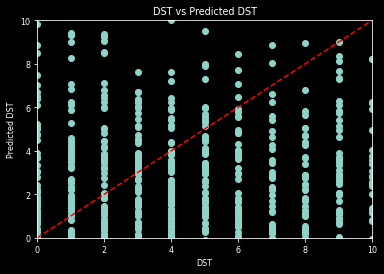

In [564]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,y_test_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,y_test_pred)))

plt.axis([0,10,0,10])
plt.scatter(y_test, y_test_pred)

index_arr = [n for n in range(11)]
plt.plot(index_arr,'r--')             
plt.xlabel("DST")
plt.ylabel("Predicted DST")
plt.title("DST vs Predicted DST")

No se han observan resultados del todo útiles mediante este modelo.

# Adaboost

In [651]:
from sklearn.ensemble import AdaBoostRegressor 
ada = AdaBoostRegressor(n_estimators=50,learning_rate=1)

#Fiteamos
ada.fit(X_train, y_train)
#Predecimos
y_pred = ada.predict(X_test)

score = r2_score(y_test, y_pred)

print("R2:", score)
print("R2 adjusted:", 1 - (1-score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,y_pred))
print('Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(y_test,y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

R2: 0.006815891048864264
R2 adjusted: 0.006263754008086431
Mean Absolute Error: 14.886106565410834
Mean Absolute Percentage Error: 2010536588268567.0
Mean Squared Error: 395.4466113251206
Root Mean Squared Error: 19.885839467448204


Mean Absolute Error: 10.481059135200033
Mean Squared Error: 264.89220049316083
Root Mean Squared Error: 16.275509223774254


Text(0.5, 1.0, 'DST vs Predicted DST')

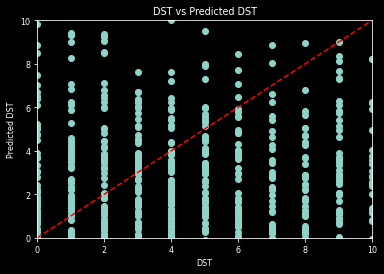

In [642]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,y_test_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,y_test_pred)))

plt.axis([0,10,0,10])
plt.scatter(y_test, y_test_pred)

index_arr = [n for n in range(11)]
plt.plot(index_arr,'r--')             
plt.xlabel("DST")
plt.ylabel("Predicted DST")
plt.title("DST vs Predicted DST")

# XG Boost

In [653]:
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#Creamos el objeteo XGBoost
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)
#Fiteamos
regressor.fit(X_train, y_train)
#Predecimos
y_pred = regressor.predict(X_test)
mean_squared_error(y_test, y_pred)

score = r2_score(y_test, y_pred)

print("R2:", score)
print("R2 adjusted:", 1 - (1-score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,y_pred))
print('Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(y_test,y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

R2: 0.39397872791409916
R2 adjusted: 0.3936418248275493
Mean Absolute Error: 10.112469314594442
Mean Absolute Percentage Error: 965830948510645.8
Mean Squared Error: 241.2936899387091
Root Mean Squared Error: 15.533630932229242


Podemos ver que se obtiene un R2 de casi 0.4, que no es del todo bueno, pero como un primer acercamiento lo consideramos aceptable.

Mean Absolute Error: 10.481059135200033
Mean Squared Error: 264.89220049316083
Root Mean Squared Error: 16.275509223774254


Text(0.5, 1.0, 'DST vs Predicted DST')

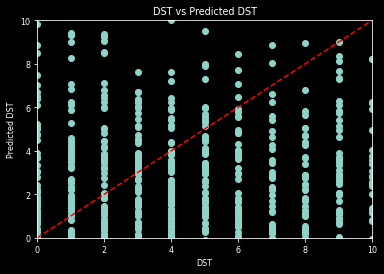

In [654]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,y_test_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,y_test_pred)))

plt.axis([0,10,0,10])
plt.scatter(y_test, y_test_pred)

index_arr = [n for n in range(11)]
plt.plot(index_arr,'r--')           
plt.xlabel("DST")
plt.ylabel("Predicted DST")
plt.title("DST vs Predicted DST")

In [655]:
#Convertimos en df la salida
df = pd.DataFrame({'Actual':y_test, 'Predicted': y_test_pred})
df

,Actual,Predicted
0,-20,-10.690606
1,-5,-2.154590
2,-8,-1.065321
3,-4,-7.919215
4,5,-19.456831
...,...,...
8995,-34,-29.383053
8996,-30,-29.903192
8997,-16,-27.174595
8998,-13,-6.938579


### Optimización de hiperparámetros

In [645]:
'''
# OPTIMIZAICIÓN DE HIPERPARÁMETROS PARA XGBOOST USANDO GRIDSEARCH NO SE REALIZA POR FALTA DE TIEMPO


from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

#Grilla ara el Random Search
hyperparameter_grid = {
    'n_estimators': [100, 500, 900, 1100, 1500],
    'max_depth': [2, 3, 5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.15, 0.20],
    'min_child_weight': [1, 2, 3, 4]
    }
#Aplico la grilla al modelo
model = RandomizedSearchCV(regressor, hyperparameter_grid, n_iter=100,cv=12,scoring='r2')
model.fit(X_train, y_train)

'''

"\n# OPTIMIZAICIÓN DE HIPERPARÁMETROS PARA XGBOOST USANDO GRIDSEARCH NO SE REALIZA POR FALTA DE TIEMPO\n\n\nfrom scipy.stats import loguniform\nfrom sklearn.model_selection import RandomizedSearchCV\n\n#Grilla ara el Random Search\nhyperparameter_grid = {\n    'n_estimators': [100, 500, 900, 1100, 1500],\n    'max_depth': [2, 3, 5, 10, 15],\n    'learning_rate': [0.05, 0.1, 0.15, 0.20],\n    'min_child_weight': [1, 2, 3, 4]\n    }\n#Aplico la grilla al modelo\nmodel = RandomizedSearchCV(regressor, hyperparameter_grid, n_iter=100,cv=12,scoring='r2')\nmodel.fit(X_train, y_train)\n\n"

In [ ]:
'''
from sklearn.metrics import accuracy_score
print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_))
'''